In [5]:
import numpy as np
import pandas as pd
import pulp
import seaborn as sns

In [62]:
md = pd.DataFrame(
    columns=('EmployeeName', 'MinHours', 'MaxHours', 'HourlyWage', 'Start', 'End'),
    data=[
        (   'SMITH', 6, 8, 30,  6, 20),
        ( 'JOHNSON', 6, 8, 50,  0, 24),
        ('WILLIAMS', 6, 8, 30,  0, 24),
        (   'JONES', 6, 8, 30,  0, 24),
        (   'BROWN', 6, 8, 40,  0, 24),
        (   'DAVIS', 6, 8, 50,  0, 24),
        (  'MILLER', 6, 8, 45,  6, 18),
        (  'WILSON', 6, 8, 30,  0, 24),
        (   'MOORE', 6, 8, 35,  0, 24),
        (  'TAYLOR', 6, 8, 40,  0, 24),
        ('ANDERSON', 2, 3, 60, 18, 24 + 6),
        (  'THOMAS', 2, 4, 40,  0, 24),
        ( 'JACKSON', 2, 4, 60,  8, 16),
        (   'WHITE', 2, 6, 55,  0, 24),
        (  'HARRIS', 2, 6, 45,  0, 24),
        (  'MARTIN', 2, 3, 40,  0, 24),
        ('THOMPSON', 2, 5, 50, 12, 24),
        (  'GARCIA', 2, 4, 50,  0, 24),
        ('MARTINEZ', 2, 4, 40,  0, 24),
        ('ROBINSON', 2, 5, 50,  0, 24),
    ],
).set_index(keys='EmployeeName', drop=True).sort_index()

# Hourly staffing requirements, over 24 hours only
hour48 = pd.RangeIndex(name='Hour', start=0, stop=48)
required = pd.Series(
    name='Required', index=hour48[:24],
    data=(1, 1, 2, 3, 6, 6, 7, 8, 9, 8, 8, 8, 7, 6, 6, 5, 5, 4, 4, 3, 2, 2, 2, 2),
)

# Long-style employee-hour selection variables, multi-indexed by employee and hour
flat = pd.DataFrame(
    data=pulp.LpVariable.matrix(name='sel', indices=(md.index, hour48), cat=pulp.LpBinary),
    index=md.index, columns=hour48,
).stack()
flat.name = 'Select'

# For each employee and available hour, each selection variable beside the employee data
lp_vars = pd.merge(
    left=md, right=flat, on='EmployeeName',
).set_index(flat.index)
hour_idx = lp_vars.index.get_level_values('Hour')
lp_vars = lp_vars[
    (hour_idx >= lp_vars['Start']) &
    (hour_idx < lp_vars['End'])
]

# The expense for each employee, as affine expressions
md['Duration'] = lp_vars['Select'].groupby('EmployeeName').agg(pulp.lpSum)
md['Expense'] = md['HourlyWage'] * md['Duration']

model = pulp.LpProblem(name='Work_Schedule', sense=pulp.LpMinimize)
model.setObjective(pulp.lpSum(md['Expense']))

for name, row in md.iterrows():
    model.addConstraint(
        name=f'hours_min_{name}',
        constraint=row['Duration'] >= row['MinHours'],
    )
    model.addConstraint(
        name=f'hours_max_{name}',
        constraint=row['Duration'] <= row['MaxHours'],
    )

hour_idx = lp_vars.index.get_level_values('Hour')
for hour, min_staff in required.items():
    hour_vars = lp_vars[hour_idx % 24 == hour]

    # For each hour (or the same hour in the next day), enforce minimum staff
    model.addConstraint(
        name=f'min_staff_{hour}',
        constraint=pulp.lpSum(hour_vars['Select']) >= min_staff,
    )

for name, selects in lp_vars['Select'].groupby('EmployeeName'):
    selects = selects.droplevel('EmployeeName')

    # At the beginning and end of the day, within the minimum number of working hours, the
    # selector values are simply monotonic
    employee = md.loc[name]
    nmin = employee['MinHours']
    for s0, s1 in zip(selects[:nmin-1], selects[1: nmin]):
        model.addConstraint(s0 <= s1)
    for s0, s1 in zip(selects[-nmin: -1], selects[1-nmin:]):
        model.addConstraint(s0 >= s1)

    # In the middle of the day, conditionally enforce monotonicity based on selection
    M = 48
    for i in range(nmin-1, selects.size-nmin):
        model.addConstraint(
            name=f'm_{name}_{selects.index[i]}',
            constraint=M*selects.iloc[i] <=
                       M*(selects.iloc[i+1] + 1) -
                       pulp.lpSum(selects.iloc[i+2: 1-nmin]),
        )

print(model)
model.solve()
if model.status != pulp.LpStatusOptimal:
    raise ValueError(model.status)

md['Duration'] = md['Duration'].map(pulp.LpAffineExpression.value)
md['Expense'] = md['Expense'].map(pulp.LpAffineExpression.value)

lp_vars['Select'] = lp_vars['Select'].map(pulp.LpVariable.value)

pd.options.display.width = 200
pd.options.display.max_columns = 99
#print(md)

hours_total = lp_vars['Select'].groupby('Hour').sum()
next_day = hours_total[required.size:]
hours_total[:next_day.size] += next_day.values
print(pd.DataFrame({
    'required': required,
    'allocated': hours_total[:required.size],
}))
print(
    lp_vars['Select']
    .astype(int)
    .unstack('Hour', fill_value=0)
    .sort_index(axis=1)
)

Work_Schedule:
MINIMIZE
60*sel_ANDERSON_18 + 60*sel_ANDERSON_19 + 60*sel_ANDERSON_20 + 60*sel_ANDERSON_21 + 60*sel_ANDERSON_22 + 60*sel_ANDERSON_23 + 60*sel_ANDERSON_24 + 60*sel_ANDERSON_25 + 60*sel_ANDERSON_26 + 60*sel_ANDERSON_27 + 60*sel_ANDERSON_28 + 60*sel_ANDERSON_29 + 40*sel_BROWN_0 + 40*sel_BROWN_1 + 40*sel_BROWN_10 + 40*sel_BROWN_11 + 40*sel_BROWN_12 + 40*sel_BROWN_13 + 40*sel_BROWN_14 + 40*sel_BROWN_15 + 40*sel_BROWN_16 + 40*sel_BROWN_17 + 40*sel_BROWN_18 + 40*sel_BROWN_19 + 40*sel_BROWN_2 + 40*sel_BROWN_20 + 40*sel_BROWN_21 + 40*sel_BROWN_22 + 40*sel_BROWN_23 + 40*sel_BROWN_3 + 40*sel_BROWN_4 + 40*sel_BROWN_5 + 40*sel_BROWN_6 + 40*sel_BROWN_7 + 40*sel_BROWN_8 + 40*sel_BROWN_9 + 50*sel_DAVIS_0 + 50*sel_DAVIS_1 + 50*sel_DAVIS_10 + 50*sel_DAVIS_11 + 50*sel_DAVIS_12 + 50*sel_DAVIS_13 + 50*sel_DAVIS_14 + 50*sel_DAVIS_15 + 50*sel_DAVIS_16 + 50*sel_DAVIS_17 + 50*sel_DAVIS_18 + 50*sel_DAVIS_19 + 50*sel_DAVIS_2 + 50*sel_DAVIS_20 + 50*sel_DAVIS_21 + 50*sel_DAVIS_22 + 50*sel_DAVIS_23 +

In [53]:
data = lp_vars.reset_index(drop=False)

In [54]:
data1 = pd.pivot_table(data[data['Select']==1], values = 'HourlyWage', index = ['EmployeeName'], columns= ['Hour'], aggfunc=np.sum, fill_value=0)


<AxesSubplot:xlabel='Hour', ylabel='EmployeeName'>

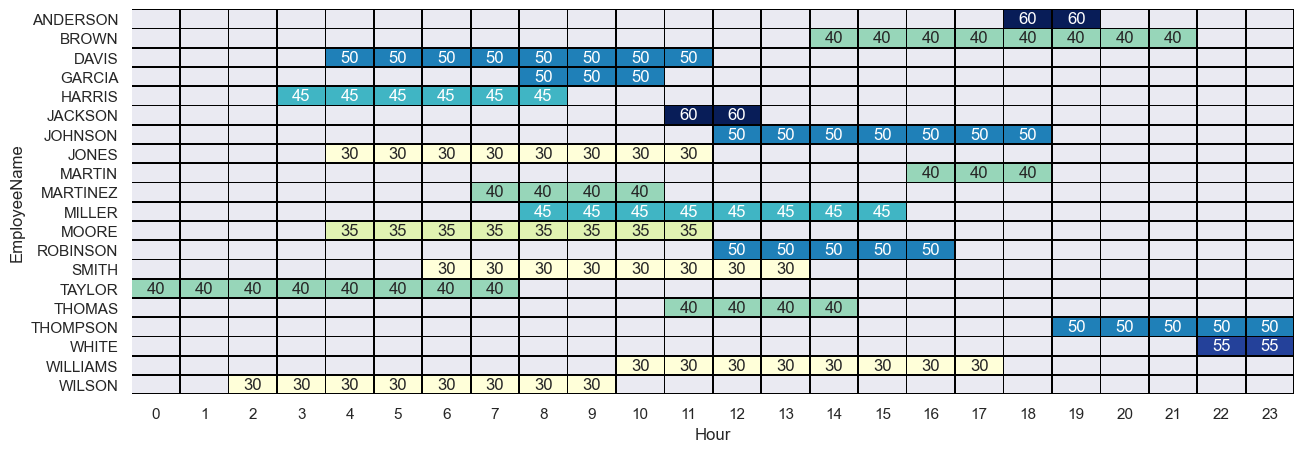

In [55]:
#sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(15, 5)})
sns.heatmap(data1, mask=(data1==0), linewidths=.5, linecolor='black', annot=True, square=False, cbar=False, cmap="YlGnBu")
#sns.set_theme()
#1, 1, 2, 3, 6, 6, 7, 8, 9, 8, 8, 8, 7, 6, 6, 5, 5, 4, 4, 3, 2, 2, 2, 2

In [56]:
data2 = data1.reset_index(drop=False)

In [57]:
np.sum(np.sum(data2.iloc[:,1:]))

4700

In [49]:
np.count_nonzero(data2.iloc[:,1:], axis=0)==required.ravel()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])